# Abe's knot with 19 crossings

## Modules

In [1]:
import numpy as np
import pandas as pd

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

from GridPythonModule import *
from GPM_wrapper import *
from knot_floer_homology import *

# ----- Debugger -----
# from IPython.core.debugger import Pdb; Pdb().set_trace()

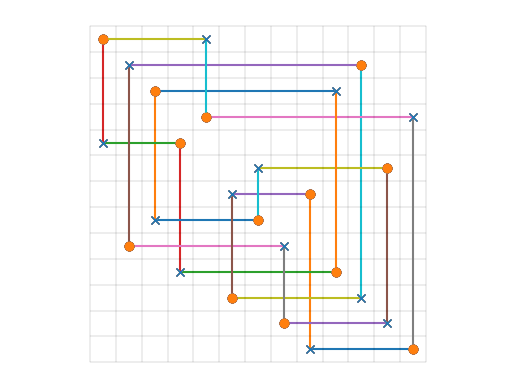

crossing number: 19


In [2]:
abe_knot_grid = [[8,11,10,3,7,2,5,6,0,12,9,1,4],[12,7,5,9,1,6,8,11,3,4,2,10,0]]
abe_knot = Grid(*abe_knot_grid)

abe_knot.draw()
print(f"crossing number: {len(abe_knot.crossings)}")

In [4]:
PD = abe_knot.get_PD(); print(f"PD notation: \n {PD}\n")
hfk = pd_to_hfk(PD); print(f"hfk values: \n {hfk}\n")

PD notation: 
 [[20, 37, 21, 0], [30, 22, 31, 21], [29, 36, 30, 37], [8, 31, 9, 32], [9, 22, 10, 23], [10, 36, 11, 35], [24, 7, 25, 8], [23, 33, 24, 32], [15, 7, 16, 6], [16, 33, 17, 34], [34, 17, 35, 18], [18, 11, 19, 12], [19, 29, 20, 28], [4, 25, 5, 26], [5, 15, 6, 14], [1, 13, 2, 12], [0, 27, 1, 28], [13, 3, 14, 2], [26, 3, 27, 4]]

hfk values: 
 {'L_space_knot': False, 'epsilon': 0, 'fibered': True, 'modulus': 2, 'nu': 0, 'ranks': {(-2, -4): 1, (-1, -3): 2, (-1, -1): 1, (0, -2): 2, (0, 0): 3, (1, -1): 2, (1, 1): 1, (2, 0): 1}, 'seifert_genus': 2, 'tau': 0, 'total_rank': 13}



'ranks' の最後が (2, 0): 1 となってますが、('maslov gr(=genus)', 'alexander gr'): rank  ですから、ラムダは 0 のようですね。

また、鏡像も見ておくと、今度は 'ranks' の最初を見て、(-2, -4): 1 とありますので、鏡像のラムダは 4 ですね。

In [ ]:
for mgr, agr in hfk['ranks'].keys():
    if mgr == hfk['seifert_genus']:
        lmd = agr
output = {'cr': 19, 'seifert_genus': mgr, 'lmd': lmd, 'ranks': hfk['ranks'], 'grid': abe_knot.orig, 'PD notation': PD}
df = pd.DataFrame(output); display(df)

## Scratch

In [ ]:
result = []
N, gsize = 100, 30

with tqdm(total=N, desc = '# of required knots') as pbar:
    while len(result) < N:
        ### Collect fitted grids
        Glist, Glist_len = [], 80
        with tqdm(total=Glist_len, desc = 'generating Glist') as pbar_Glist:
            fails, fmax = 0, 100
            while len(Glist) < Glist_len and fails < fmax:
                with Pool(processes=8) as pool:
                    grids = [generate_random_grid(gsize) for _ in range(100)]
                    output = [v for v in pool.map(get_fitted_grid, grids) if v is not None]
                    if len(output) > 0: 
                        Glist += output
                        pbar_Glist.update(len(output))
                    else:
                        fails += 1
            if fails >= fmax:
                print(f"Fail to generate Glist {fails} times!")
                break

        ### Collect knots satisfying seifert genus > lamda
        with Pool(processes=8) as pool:
            output = [v for v in list(tqdm(pool.imap(calc_lmd, Glist), total = len(Glist), desc='hfk calc')) if v is not None]
            if len(output) > 0:
                result += output
                pbar.update(len(output))
#---
DF = pd.DataFrame(result); display(DF)
DF.to_csv(f"./data/big_knots_with_small_lambda.csv", mode = 'a', index=False, header = False) #True)

In [ ]:
flag, count = True, 0
while flag:
    count += 1
    G = generate_random_grid(30);
    Glist = [G, destabilize_all(G), simplify_grid(G)]
    cnlist = list(map(lambda g: crossing_number(g), Glist))
    if cnlist[0] < cnlist[2] or cnlist[0] < cnlist[1]:
        flag = False
        for g in Glist:
            draw_grid(g); print(crossing_number(g))
    if count > 1000:
        flag = False